In [1]:
import os
import sys

local_path = os.getcwd()
# 设置工作目录为项目的主目录
os.chdir(os.path.join(local_path, "../../"))  # 使用相对路径将工作目录切换到 project 文件夹
print("Current working directory:", os.getcwd())
project_path = os.path.abspath(os.path.join(local_path, "../../"))
sys.path.append(project_path)   #将模块查找路径切换

import torch
# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from utils import *
set_seed(42)  # 42 是一个示例种子数，您可以根据需求更改

Current working directory: /home/yixiong_ren/work/FBM
Using device: cuda


# 加载数据集

In [2]:
class_counts = [100]*10
datatype = 'MNIST'
images_size = 1*28*28

trainloader = get_dataloader(datatype, batch_size=64, train=True, class_counts=class_counts)
testloader = get_dataloader(datatype, batch_size=64, train=False)

# 神经网络相关包

In [3]:
import torch.optim as optim
import torch.nn.functional as F
from loss.loss import FBMLoss
from models.modelset import FBMLayer
from models.modelset import FBM_KANLayer
from models.modelset import MLP

import torch
import torch.nn as nn

# 卷积神经网络

In [36]:
# 2. 定义CNN模型

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 输入1通道，输出32通道，卷积核大小为3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 输入32通道，输出64通道，卷积核大小为3x3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 输入64通道，输出128通道，卷积核大小为3x3
        # 全连接层
        self.fc1 = nn.Linear(128 * 7 * 7, 128)  # 输入128 * 7 * 7，输出128

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)  # 最大池化层，步长为2
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)  # 最大池化层，步长为2
        x = torch.relu(self.conv3(x))
        #x = torch.max_pool2d(x, 2)  # 最大池化层，步长为2
        
        # 打印当前张量的形状，调试用
        #print(f"Shape before flatten: {x.shape}")

        # 根据打印的形状来展平张量
        x = x.view(x.size(0), -1)  # 将张量展平成一维

        x = self.fc1(x)
        #x = torch.relu(self.fc1(x))
        #out = (torch.tanh(x) + 1)/2.0
        #x = self.fc2(x)
        return x
'''
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 输入1通道，输出32通道，卷积核大小为3x3
        # 全连接层
        self.fc1 = nn.Linear(16 * 14 * 14, 1000)  # 输入128 * 14 * 14，输出1000

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)  # 最大池化层，步长为2

        x = x.view(x.size(0), -1)  # 将张量展平成一维
        x = self.fc1(x)
        out = (torch.tanh(x) + 1)/2.0

        return x
'''

# 3. 初始化模型
model = CNN().to(device)

# 4. 定义损失函数和优化器
#criterion = nn.CrossEntropyLoss()  # 交叉熵损失
optimizer = optim.Adam(model.parameters(), lr=0.001)
hidden_dim=1000
df = 0.35
criterion = FBMLoss(hidden_dim, 0.001, df, 1, losstype="fast_FermiBose")

# 5. 训练模型
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        labels = labels.to(device)
        
        # 前向传播
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    correct = MLP_accuracy(trainloader, trainloader, model=model, device=device)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}, Accuracy: {100 * correct}%")

# 6. 测试模型

MLP_correct, MLPlayer = MLP_accuracy(trainloader, testloader, model=model, device=device, get_model=True)
KMeans_correct = KMeans_accuracy(testloader, model=model, device=device)

print(f"Test MLP Accuracy: {100 * MLP_correct }%")
print(f"Test KMeans Accuracy: {100 * KMeans_correct }%")


Epoch [1/10], Loss: 0.2337, Accuracy: 91.10000000000001%
Epoch [2/10], Loss: 0.1499, Accuracy: 95.39999999999999%
Epoch [3/10], Loss: 0.1127, Accuracy: 97.7%
Epoch [4/10], Loss: 0.0922, Accuracy: 98.5%
Epoch [5/10], Loss: 0.0743, Accuracy: 98.9%
Epoch [6/10], Loss: 0.0684, Accuracy: 99.7%
Epoch [7/10], Loss: 0.0547, Accuracy: 99.9%
Epoch [8/10], Loss: 0.0477, Accuracy: 100.0%
Epoch [9/10], Loss: 0.0411, Accuracy: 100.0%
Epoch [10/10], Loss: 0.0351, Accuracy: 100.0%
Test MLP Accuracy: 94.3%
Test KMeans Accuracy: 95.1%


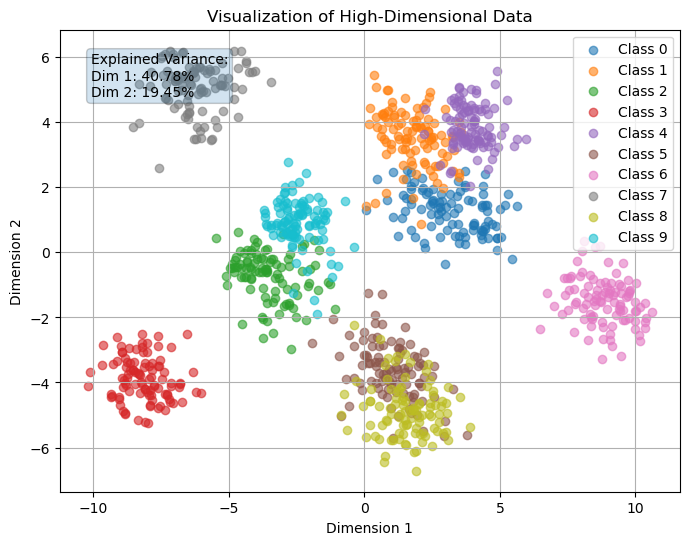

In [37]:
visualize_2d(trainloader, model, device)

## 对抗性攻击

Epsilon: 0	Test Accuracy = 0.2280
Epsilon: 0.05	Test Accuracy = 0.2240
Epsilon: 0.1	Test Accuracy = 0.2210
Epsilon: 0.15	Test Accuracy = 0.2200
Epsilon: 0.2	Test Accuracy = 0.2200


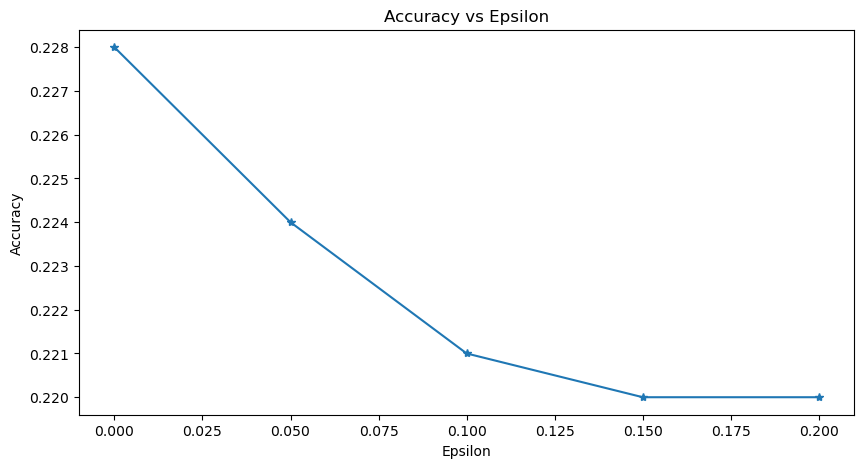

In [23]:
# FGSM攻击函数
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    return perturbed_image

# 对抗样本生成
def test(model_list, device, test_loader, epsilon):
    correct = 0
    adv_examples = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        inputdata = data
        for model in model_list:
            inputdata = model(inputdata)
        output = inputdata
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue

        loss = nn.CrossEntropyLoss()(output, target)
        for model in model_list:
            model.zero_grad()
        loss.backward()
        data_grad = data.grad
        #print(data_grad)

        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = perturbed_data
        for model in model_list:
            output = model(output)
        final_pred = output.max(1, keepdim=True)[1]

        if final_pred.item() == target.item():
            correct += 1
        else:
            adv_examples.append((init_pred.item(), final_pred.item(), perturbed_data.squeeze().detach().cpu().numpy()))

    final_acc = correct / float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {final_acc:.4f}")
    return final_acc, adv_examples

testloader = get_dataloader(datatype, batch_size=1, train=False, class_counts=class_counts)

# 执行攻击
epsilons = [0, 0.05, 0.1, 0.15, 0.2]
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test([model.eval(), MLPlayer.eval()], device, testloader, eps)
    accuracies.append(acc)
    examples.append(ex)

# 绘制攻击效果
plt.figure(figsize=(10,5))
plt.plot(epsilons, accuracies, "*-")
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Class 0: mean = 7640.4482, std = 5411.5742
Class 1: mean = 4732.9614, std = 3451.1748
Class 2: mean = 8673.8223, std = 5725.7573
Class 3: mean = 6764.1621, std = 5596.5620
Class 4: mean = 7276.0483, std = 4869.4634
Class 5: mean = 8552.7715, std = 5317.9282
Class 6: mean = 7327.8145, std = 5438.1206
Class 7: mean = 6000.2051, std = 3611.0015
Class 8: mean = 6509.1582, std = 4865.5273
Class 9: mean = 6107.5767, std = 4752.0981


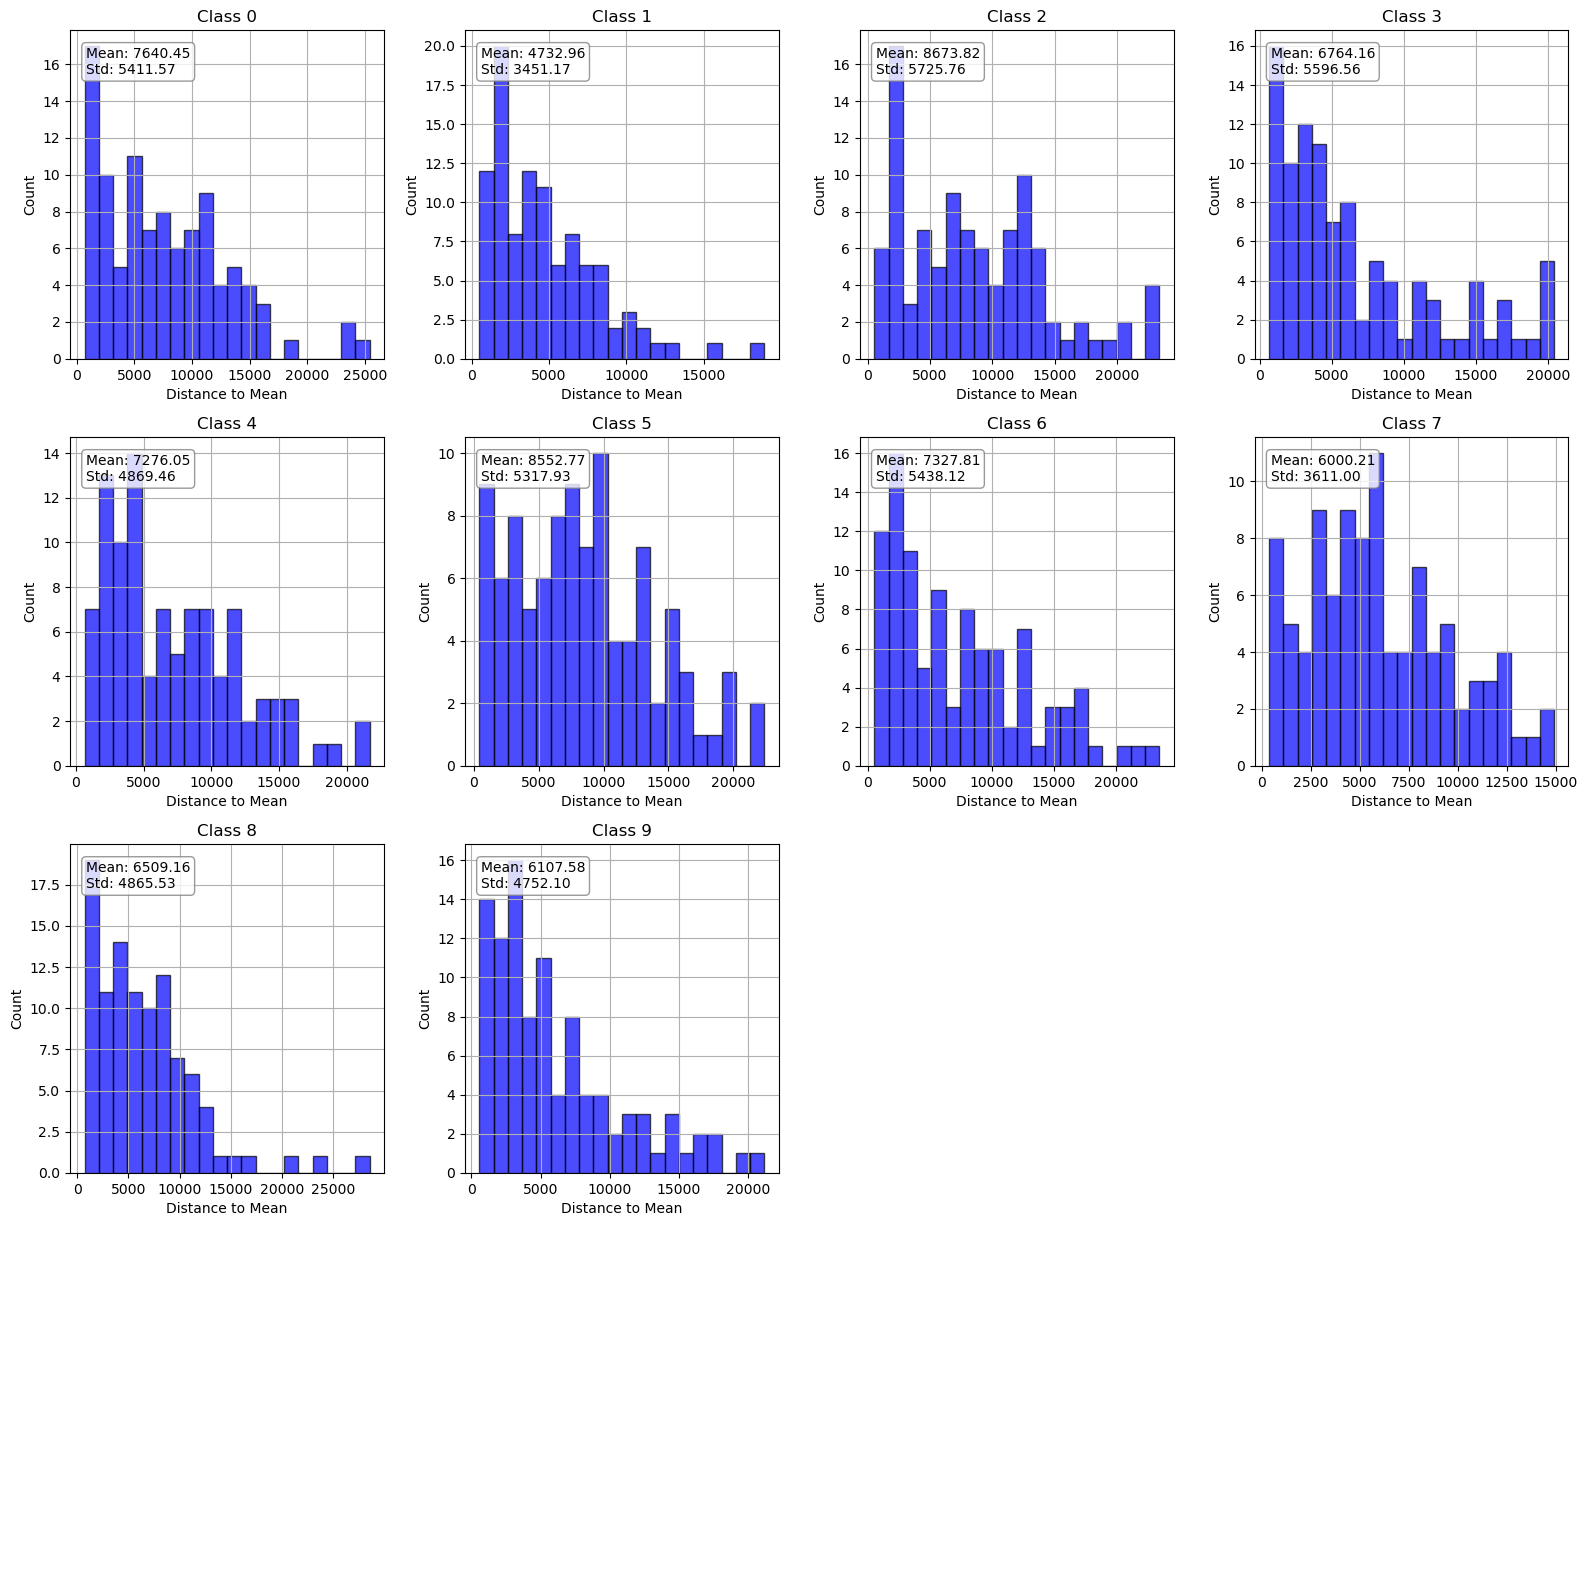

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import math


deal_test_loader = deal_dataloader(trainloader, model, device, batch_size = 64)

features, labels = next(iter(deal_test_loader))
dims = torch.prod(torch.tensor(features.shape[1:]))

# 获取 DataLoader 中的全部数据
deal_test_features = []
deal_test_labels = []

for batch_data, batch_labels in deal_test_loader:
    deal_test_features.append(batch_data.view(-1, dims))
    deal_test_labels.append(batch_labels)

# 合并所有批次
deal_test_features = torch.cat(deal_test_features, dim=0).cpu().numpy()
deal_test_labels = torch.cat(deal_test_labels, dim=0).cpu().numpy()

unique_labels = np.unique(deal_test_labels)
num_classes = len(unique_labels)

class_distances = {}
class_std = {}
class_mean = {}

for lbl in unique_labels:
    class_points = deal_test_features[deal_test_labels == lbl]
    mean_point = np.mean(class_points, axis=0)
    dists = np.linalg.norm(class_points - mean_point, axis=1)
    class_distances[lbl] = dists
    class_std[lbl] = np.std(dists)
    class_mean[lbl] = np.mean(dists)

for lbl in unique_labels:
    print(f"Class {lbl}: mean = {class_mean[lbl]:.4f}, std = {class_std[lbl]:.4f}")

# 计算n，使子图尽可能接近方阵排列
n = math.ceil(math.sqrt(num_classes))

fig, axes = plt.subplots(n, n, figsize=(4*n, 4*n))
axes = axes.flatten()  # 将子图矩阵展平为一维列表，便于迭代

# 绘制子图
for idx, lbl in enumerate(unique_labels):
    ax = axes[idx]
    dist_data = class_distances[lbl]
    ax.hist(dist_data, bins=20, alpha=0.7, color='blue', edgecolor='black')
    ax.set_title(f"Class {lbl}")
    ax.set_xlabel("Distance to Mean")
    ax.set_ylabel("Count")
    ax.grid(True)
    # 标注均值与标准差
    mean_val = class_mean[lbl]
    std_val = class_std[lbl]
    ax.text(0.05, 0.95, f"Mean: {mean_val:.2f}\nStd: {std_val:.2f}", 
            transform=ax.transAxes, verticalalignment='top', fontsize=10, 
            bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.8))

# 对于多余的子图（如果类数量不是正好n*n），隐藏它们
for idx in range(num_classes, n*n):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

Class 0: mean = 22.5407, std = 2.9505
Class 1: mean = 15.4911, std = 2.9479
Class 2: mean = 23.1043, std = 2.0293
Class 3: mean = 21.4512, std = 2.8827
Class 4: mean = 20.1677, std = 3.1472
Class 5: mean = 21.7271, std = 2.6450
Class 6: mean = 19.7926, std = 3.1888
Class 7: mean = 19.1855, std = 2.8374
Class 8: mean = 20.4100, std = 2.9009
Class 9: mean = 19.0220, std = 3.3160


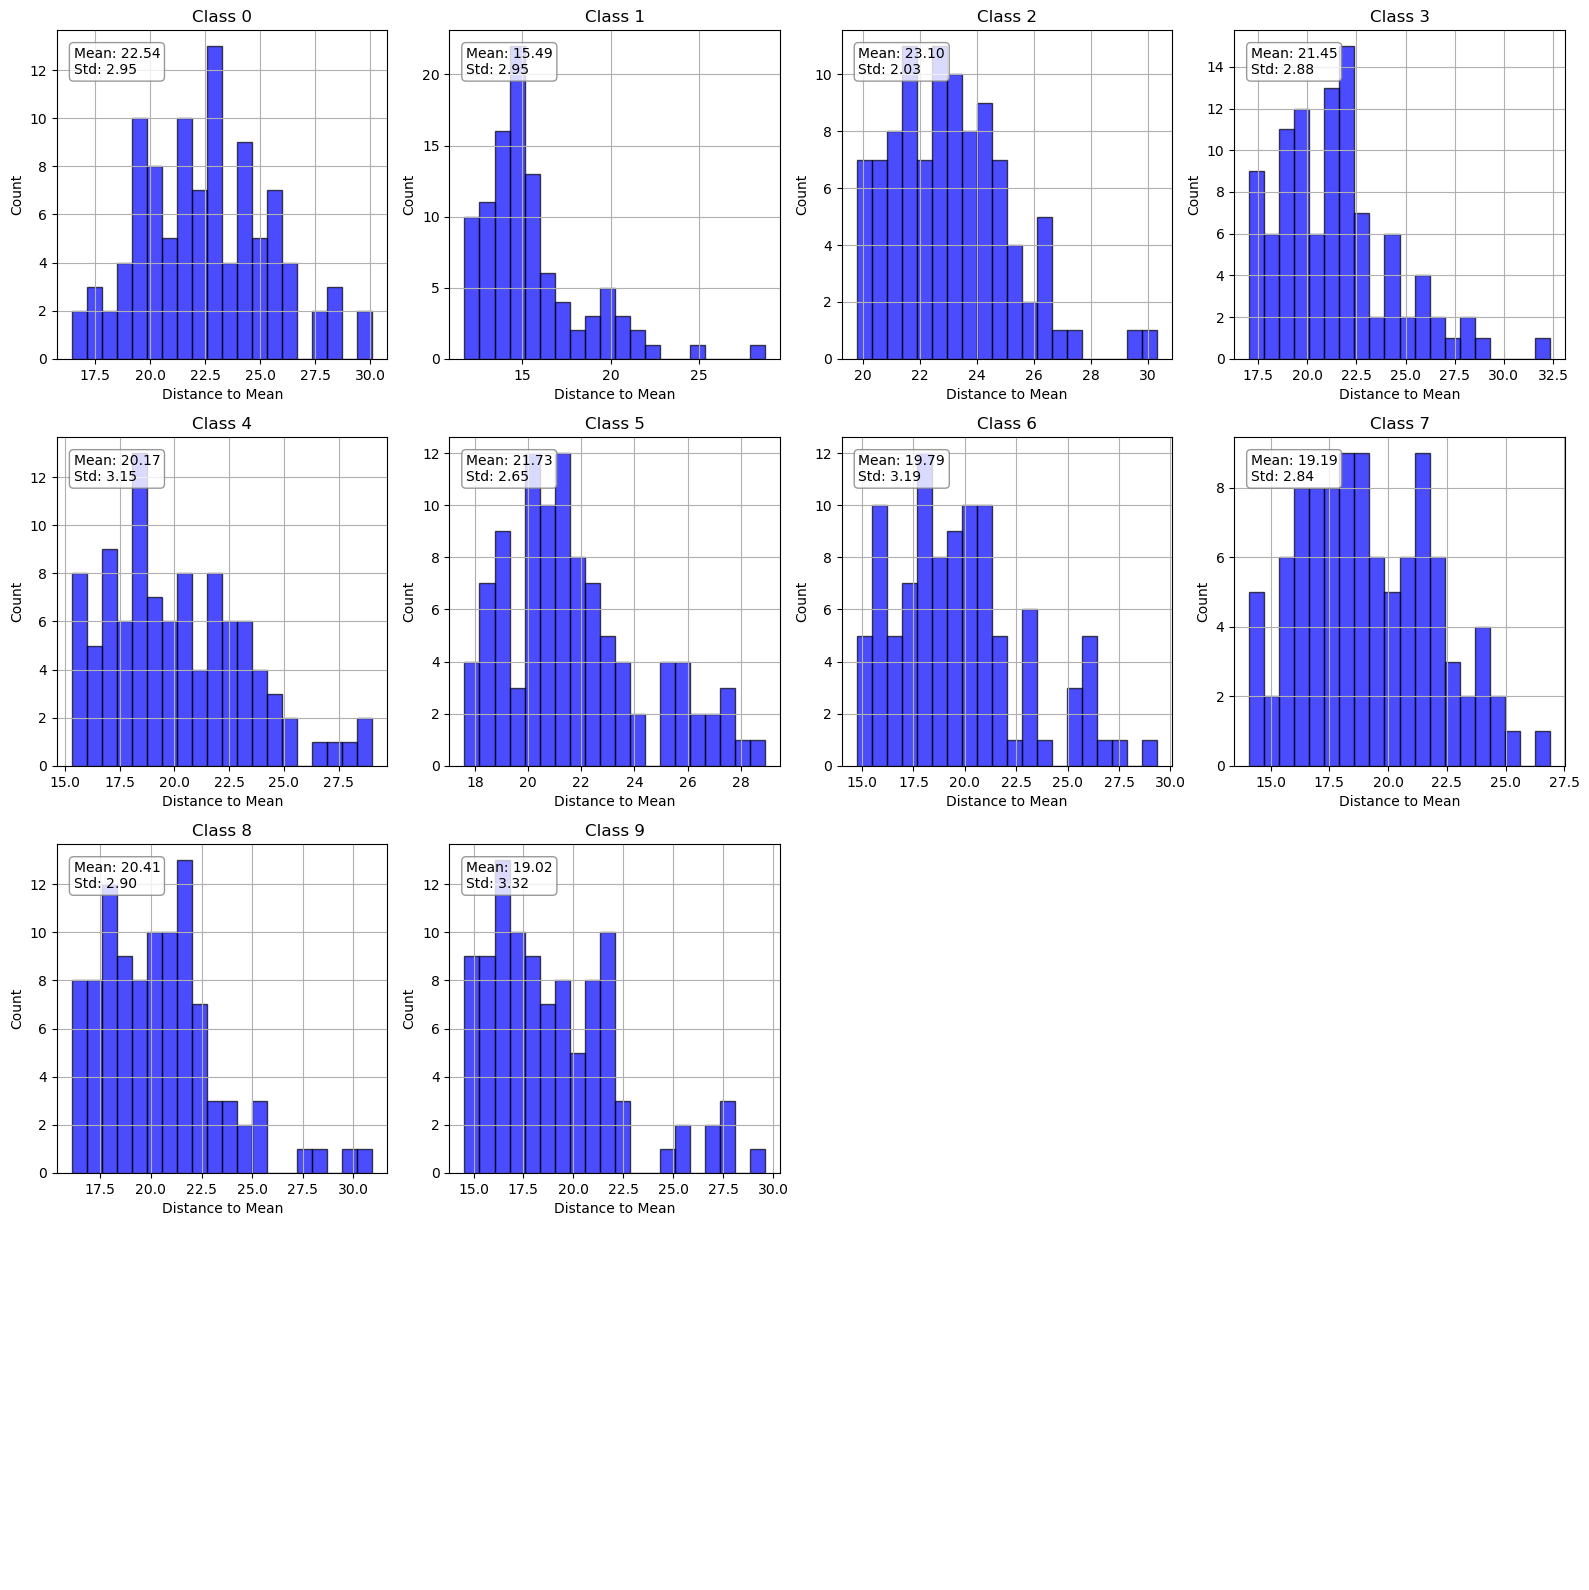

In [25]:
deal_test_loader = trainloader

features, labels = next(iter(deal_test_loader))
dims = torch.prod(torch.tensor(features.shape[1:]))

# 获取 DataLoader 中的全部数据
deal_test_features = []
deal_test_labels = []

for batch_data, batch_labels in deal_test_loader:
    deal_test_features.append(batch_data.view(-1, dims))
    deal_test_labels.append(batch_labels)

# 合并所有批次
deal_test_features = torch.cat(deal_test_features, dim=0).cpu().numpy()
deal_test_labels = torch.cat(deal_test_labels, dim=0).cpu().numpy()

unique_labels = np.unique(deal_test_labels)
num_classes = len(unique_labels)

class_distances = {}
class_std = {}
class_mean = {}

for lbl in unique_labels:
    class_points = deal_test_features[deal_test_labels == lbl]
    mean_point = np.mean(class_points, axis=0)
    dists = np.linalg.norm(class_points - mean_point, axis=1)
    class_distances[lbl] = dists
    class_std[lbl] = np.std(dists)
    class_mean[lbl] = np.mean(dists)

for lbl in unique_labels:
    print(f"Class {lbl}: mean = {class_mean[lbl]:.4f}, std = {class_std[lbl]:.4f}")

# 计算n，使子图尽可能接近方阵排列
n = math.ceil(math.sqrt(num_classes))

fig, axes = plt.subplots(n, n, figsize=(4*n, 4*n))
axes = axes.flatten()  # 将子图矩阵展平为一维列表，便于迭代

# 绘制子图
for idx, lbl in enumerate(unique_labels):
    ax = axes[idx]
    dist_data = class_distances[lbl]
    ax.hist(dist_data, bins=20, alpha=0.7, color='blue', edgecolor='black')
    ax.set_title(f"Class {lbl}")
    ax.set_xlabel("Distance to Mean")
    ax.set_ylabel("Count")
    ax.grid(True)
    # 标注均值与标准差
    mean_val = class_mean[lbl]
    std_val = class_std[lbl]
    ax.text(0.05, 0.95, f"Mean: {mean_val:.2f}\nStd: {std_val:.2f}", 
            transform=ax.transAxes, verticalalignment='top', fontsize=10, 
            bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.8))

# 对于多余的子图（如果类数量不是正好n*n），隐藏它们
for idx in range(num_classes, n*n):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [26]:

# 3. 初始化模型
model2 = CNN().to(device)
#model3 = MLP(hidden_dim, 10).to(device)
model3 = MLP(128, 10).to(device)

# 4. 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 交叉熵损失
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

# 5. 训练模型

for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        optimizer2.zero_grad()
        optimizer3.zero_grad()

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 前向传播
        outputs = model3(model2(inputs))
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        loss.backward()
        optimizer2.step()
        optimizer3.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}, Accuracy: {100 * correct/total:.2f}%")

# 6. 测试模型

MLP_correct = MLP_accuracy(trainloader, testloader, model=model2, device=device)
KMeans_correct = KMeans_accuracy(testloader, model=model2, device=device)

print(f"Test MLP Accuracy: {100 * MLP_correct }%")
print(f"Test KMeans Accuracy: {100 * KMeans_correct }%")


Epoch [1/2], Loss: 1.2041, Accuracy: 62.40%
Epoch [2/2], Loss: 0.4179, Accuracy: 86.80%


Test MLP Accuracy: 90.9%
Test KMeans Accuracy: 85.1%


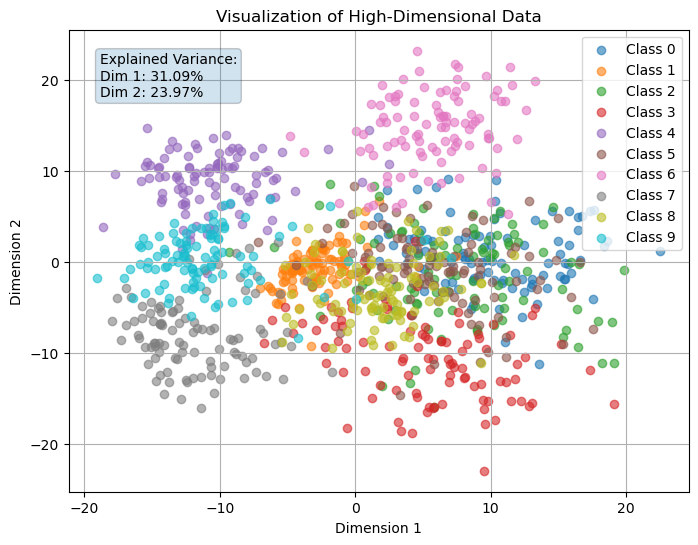

In [27]:
visualize_2d(trainloader, model2, device)

In [28]:
testloader = get_dataloader(datatype, batch_size=1, train=False, class_counts=class_counts)

# 执行攻击
epsilons = [0, 0.05, 0.1, 0.15, 0.2]
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test([model2.eval(), model3.eval()], device, testloader, eps)
    accuracies.append(acc)
    examples.append(ex)

# 绘制攻击效果
plt.figure(figsize=(10,5))
plt.plot(epsilons, accuracies, "*-")
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Epsilon: 0	Test Accuracy = 0.8820


KeyboardInterrupt: 